### Week 3 Workbook: Using Internal Measure to Evaluate Relative Intensity

In this workbook, we will use a large dataset that was derived from the women's basketball team at the University of Michigan.  We have de-identified the dataset changing player names to random Athlete ID numbers.  

As we have discussed - internal measures can be a bit more finicky than external measures.  Typically, they need to have some contact with the skin surface (e.g. for measuring the heart or the skeletal muscle electrical activity).  As a result, there are definitely better and worse collections regarding internal measures that depend (largely) upon good skin surface contact.  

We have included three games in this dataset -- but we have highlighted a single game in this analysis.  I have cherry-picked a game that has pretty solid heart rate data for the majority of the players. 

So...let's get started! 


### Import LIbraries and Dataset

In [1]:
# we have 10 Hz datasets from a number of athletes -- over separate games (UM Women's Basketball from 2019)


#imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
import matplotlib.dates as mdates

from datetime import datetime
import plotly.graph_objects as go

It can be really helpful to read in the date / time info into the dataframe index -- so that is our strategy here: 

In [2]:
df = pd.read_csv("../Data/WBBtotal.csv", index_col =["Timestamp"], parse_dates=["Timestamp"])
df.head()

,Seconds,Velocity,Acceleration,Odometer,Latitude,Longitude,Heart Rate,Player Load,AthleteID
Timestamp,,,,,,,,,
2019-01-08 17:39:42,0.0,0,0,0,0,0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.1,0,0,0,0,0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.2,0,0,0,0,0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.3,0,0,0,0,0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.4,0,0,0,0,0,83,0.0,Athlete 1


### Data Overview

This is a typical Catapult Sports dataset export.  It includes GPS measures - but because basketball is an indoor sport - we will NOT have any GPS measures such as velocity, odometer (distance), latitude or longitude.  So, we will eliminate these columns and focus on those that have meaningful data... while also making a copy of the original dataset into our new dataset called "df_wbb".

In [3]:
columns_to_keep = ['Seconds','Heart Rate', 'Player Load', 'AthleteID']

df_wbb = df[columns_to_keep]
df_wbb

,Seconds,Heart Rate,Player Load,AthleteID
Timestamp,,,,
2019-01-08 17:39:42,0.0,83,0.0,Athlete 1
2019-01-08 17:39:42,0.1,83,0.0,Athlete 1
2019-01-08 17:39:42,0.2,83,0.0,Athlete 1
2019-01-08 17:39:42,0.3,83,0.0,Athlete 1
2019-01-08 17:39:42,0.4,83,0.0,Athlete 1
...,...,...,...,...
2019-03-08 16:47:03,11484.4,101,1001.5,Athlete 5
2019-03-08 16:47:03,11484.5,101,1001.5,Athlete 5
2019-03-08 16:47:03,11484.6,101,1001.5,Athlete 5


So -- we have about 4 millions lines here -- so it can become a little cumbersome.  

Next, let's see what different game dates we have in the dataset by turning to the index and looking for unique dates within the timestamp.

In [4]:
# Get unique game days from within the dataset -- it might run slowly -- in which case it is not necessary
df_wbb.index.map(pd.Timestamp.date).unique()

Index([2019-01-08, 2019-03-09, 2019-03-08], dtype='object', name='Timestamp')

Next, let's look at the number and label of the different athletes in the dataset.

In [5]:
# Get unique Athlete IDs
uniqueValues = (df_wbb['AthleteID'].unique())
print(uniqueValues)

['Athlete 1' 'Athlete 12' 'Athlete 10' 'Athlete 3' 'Athlete 13'
 'Athlete 2' 'Athlete 11' 'Athlete 6' 'Athlete 4' 'Athlete 9' 'Athlete 8'
 'Athlete 7' 'Athlete 5']


In [6]:
print(df_wbb.columns)

Index(['Seconds', 'Heart Rate', 'Player Load', 'AthleteID'], dtype='object')


### Data Preparation

Let's reduce the size of our dataset and the scope of our analysis by reducing our dataset to just the March 8th (2019-03-08) game.  As the index is time  I will name the dataframe: "Game_3_8_df".

In [7]:
Game_3_8_df = df_wbb.loc['2019-03-08']
Game_3_8_df

,Seconds,Heart Rate,Player Load,AthleteID
Timestamp,,,,
2019-03-08 13:35:00,0.0,0,0.0,Athlete 9
2019-03-08 13:35:00,0.1,0,0.0,Athlete 9
2019-03-08 13:35:00,0.2,0,0.0,Athlete 9
2019-03-08 13:35:00,0.3,0,0.0,Athlete 9
2019-03-08 13:35:00,0.4,0,0.1,Athlete 9
...,...,...,...,...
2019-03-08 16:47:03,11484.4,101,1001.5,Athlete 5
2019-03-08 16:47:03,11484.5,101,1001.5,Athlete 5
2019-03-08 16:47:03,11484.6,101,1001.5,Athlete 5


We are now down to just over a million lines of code  - representing an entire basketball game (for most of the roster) broken down into 1/10th of a second (ie. 10 hertz) collections.  



### Evaluating the dataset (preparing to clean the dataset)

Our biggest concern for this analysis is how much of the heart rate data might not be "real".    So, we can start by getting a count (ie. a sum) of all the zeroes in the dataset this way: (axis=0 is used for columns)

In [8]:
(Game_3_8_df == 0).sum(axis=0)  # we are just capturing the number of cells with a zero in them for each column in the entire team dataframe

Seconds          13
Heart Rate     9106
Player Load     218
AthleteID         0
dtype: int64

In this first step of investigating the quality of the heart rate data -- there are definitely concerns.  Whereas the playerload and the "seconds" measures should have zero values - we should not have any athletes having a heart rate of zero! 

However, the Catapult devices are turned on in some cases before the heart rate strap is in place - which would result in a zero value.  However, in this case we have about 9 thousand zeroes to contend with -- across about a million cells of HR data.  So, we want to know where these zeroes are occuring in order to decide how much of a problem they are.

Let's grab a dataset from one player to get a direct look at the HR data.

In [9]:
Ath12_Game_3_8_df = Game_3_8_df.loc[Game_3_8_df['AthleteID'] == 'Athlete 12']   # we are choosing to look at athlete 12 for a quick look
Ath12_Game_3_8_df

,Seconds,Heart Rate,Player Load,AthleteID
Timestamp,,,,
2019-03-08 13:35:31,0.0,93,0.0,Athlete 12
2019-03-08 13:35:31,0.1,93,0.0,Athlete 12
2019-03-08 13:35:31,0.2,93,0.0,Athlete 12
2019-03-08 13:35:31,0.3,93,0.0,Athlete 12
2019-03-08 13:35:31,0.4,95,0.0,Athlete 12
...,...,...,...,...
2019-03-08 16:45:33,11402.7,107,311.2,Athlete 12
2019-03-08 16:45:33,11402.8,107,311.2,Athlete 12
2019-03-08 16:45:33,11402.9,107,311.2,Athlete 12


Let's take a quick look at the data from this randomly selected athlete:

<AxesSubplot:xlabel='Seconds'>

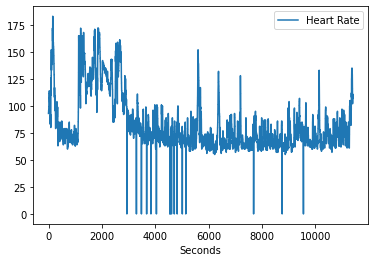

In [10]:
Ath12_Game_3_8_df.plot(x='Seconds', y='Heart Rate') # Simple plot from dataframe of Athlete 12 from the game on 03

The spots where the values drop down to zero are problematic .  We want to get rid of any zero values for HR -- as that is not (physiologically) possible and it will disrupt our analyses.   Logistically, this happens due to a transient loss of signal from the sensor (in this case a chest-strap for heart electrical activity (ECG)).  

Let's jump back to the whole team dataset and get a more granular look at the heart rate data.  Let's get it broken down for each player.  We'll use the "agg" method to find the minimum ("min") value, average, maximum and length of the values according to each athlete ID (ie. player) using the groupby method that we have used before:  

In [11]:
# The following will look at each athelete and, for each of our columns of seconds, heart rate, and player load
# we will generate the min, average, and max values
Game_3_8_df.groupby('AthleteID').agg([min,np.average,max,len])

Seconds                             Heart Rate                   \
               min  average      max       len        min     average  max   
AthleteID                                                                    
Athlete 1      0.0  5370.00  10740.0  107401.0          0  148.808065  221   
Athlete 10     0.0  5681.20  11362.4  113625.0          0  146.928466  217   
Athlete 11     0.0  5713.00  11426.0  114261.0          0   95.902136  211   
Athlete 12     0.0  5701.55  11403.1  114032.0          0   83.491809  183   
Athlete 13     0.0  5704.30  11408.6  114087.0          0   97.911620  165   
Athlete 2      0.0  5691.90  11383.8  113839.0          0  108.144494  206   
Athlete 3      0.0  5746.50  11493.0  114931.0          0  101.555638  220   
Athlete 4      0.0  5722.20  11444.4  114445.0          0   84.282773  185   
Athlete 5      0.0  5742.40  11484.8  114849.0          0  140.531463  217   
Athlete 6      0.0  5736.40  11472.8  114729.0          0  111.404606  183   
Athlete 7      0.0    29.90     59.8     599.0          0    0.000000    0   
Athlete 8      0.0  5742.90  11485.8  114859.0          0  112.379587  192   
Athlete 9      0.0  5707.20  11414.4  114145.0          0  149.165263  210   

                   Player Load                                
               len         min     average     max       len  
AthleteID                                                     
Athlete 1   107401         0.0  393.937455   837.2  107401.0  
Athlete 10  113625         0.0  601.659845  1300.7  113625.0  
Athlete 11  114261         0.0  176.135225   271.3  114261.0  
Athlete 12  114032         0.0  195.057992   311.2  114032.0  
Athlete 13  114087         0.0  186.330738   305.1  114087.0  
Athlete 2   113839         0.0  276.709051   458.6  113839.0  
Athlete 3   114931         0.0  194.991953   305.2  114931.0  
Athlete 4   114445         0.0  231.538611   384.5  114445.0  
Athlete 5   114849         0.0  485.788989  1001.5  114849.0  
Athlete 6   114729         0.0  158.246782   255.7  114729.0  
Athlete 7      599         0.0    1.649416     2.8     599.0  
Athlete 8   114859         0.0  245.621813   452.5  114859.0  
Athlete 9   114145         0.0  412.945059   958.2  114145.0

This table gives us a lot to digest.  By looking at the minimum values for heart rate here, we can see that we have at least one "zero" value for HR for EVERY player.  This can result from the device powering on prior to the heart rate strap being worn by the athlete.  So, it is not an immediate concern.  However, we really want to determine how many zero values are in the data set for each player -- and eliminate those zero values.


We can also see from this table that we have a variable number of datapoints for the different players.  This typically relates to when the devices are turned on and off.  Most of the players have a similar number of datapoints (107k to 115k).  However, Athlete 7 is a special case with only 599 observations and NO heart rate values above zero.  

### Cleaning the dataset (Eliminating heart rates of zero and athlete without HR data)

As we know that zero is not physiologically possible for heart rate, let's drop all the zero heart rate values.   We can then go back and determine how much missing HR data there is for each athlete.  We will change each value of zero (ie. ['Heart Rate'] ==0) to a non-value or "not a number" (nan).  Here is the simple code: 

In [12]:
%%capture
Game_3_8_df.loc[Game_3_8_df['Heart Rate'] ==0, 'Heart Rate'] = np.nan

Note: we have not done this for playerload - as it is possible to have "zero" as a playerload.

Now that we have eliminated all the heart rates of zero -- let's do that analysis from above again... so that we can see how many values (ie. zeroes) we just cleared out for each player.

In [13]:
# The following will look at each athelete and, for each of our columns of seconds, heart rate, and player load
# we will generate the min, average, and max values
Game_3_8_df.groupby('AthleteID').agg([min,np.average,max,len])

Seconds                             Heart Rate                 \
               min  average      max       len        min average    max   
AthleteID                                                                  
Athlete 1      0.0  5370.00  10740.0  107401.0       81.0     NaN  221.0   
Athlete 10     0.0  5681.20  11362.4  113625.0       73.0     NaN  217.0   
Athlete 11     0.0  5713.00  11426.0  114261.0       59.0     NaN  211.0   
Athlete 12     0.0  5701.55  11403.1  114032.0       55.0     NaN  183.0   
Athlete 13     0.0  5704.30  11408.6  114087.0       65.0     NaN  165.0   
Athlete 2      0.0  5691.90  11383.8  113839.0       60.0     NaN  206.0   
Athlete 3      0.0  5746.50  11493.0  114931.0       60.0     NaN  220.0   
Athlete 4      0.0  5722.20  11444.4  114445.0       52.0     NaN  185.0   
Athlete 5      0.0  5742.40  11484.8  114849.0       69.0     NaN  217.0   
Athlete 6      0.0  5736.40  11472.8  114729.0       77.0     NaN  183.0   
Athlete 7      0.0    29.90     59.8     599.0        NaN     NaN    NaN   
Athlete 8      0.0  5742.90  11485.8  114859.0       68.0     NaN  192.0   
Athlete 9      0.0  5707.20  11414.4  114145.0       63.0     NaN  210.0   

                     Player Load                                
                 len         min     average     max       len  
AthleteID                                                       
Athlete 1   107401.0         0.0  393.937455   837.2  107401.0  
Athlete 10  113625.0         0.0  601.659845  1300.7  113625.0  
Athlete 11  114261.0         0.0  176.135225   271.3  114261.0  
Athlete 12  114032.0         0.0  195.057992   311.2  114032.0  
Athlete 13  114087.0         0.0  186.330738   305.1  114087.0  
Athlete 2   113839.0         0.0  276.709051   458.6  113839.0  
Athlete 3   114931.0         0.0  194.991953   305.2  114931.0  
Athlete 4   114445.0         0.0  231.538611   384.5  114445.0  
Athlete 5   114849.0         0.0  485.788989  1001.5  114849.0  
Athlete 6   114729.0         0.0  158.246782   255.7  114729.0  
Athlete 7      599.0         0.0    1.649416     2.8     599.0  
Athlete 8   114859.0         0.0  245.621813   452.5  114859.0  
Athlete 9   114145.0         0.0  412.945059   958.2  114145.0

In [14]:
DataCount = Game_3_8_df.groupby('AthleteID')['Heart Rate','Player Load'].count()

print("Count of heart rate and playerload by player ID")
print(DataCount.sort_values(by='Heart Rate', ascending = False))

Count of heart rate and playerload by player ID
            Heart Rate  Player Load
AthleteID                          
Athlete 6       114724       114729
Athlete 8       114669       114859
Athlete 13      114080       114087
Athlete 12      113801       114032
Athlete 11      113735       114261
Athlete 5       113657       114849
Athlete 9       113526       114145
Athlete 2       113514       113839
Athlete 4       113483       114445
Athlete 10      113105       113625
Athlete 3       111080       114931
Athlete 1       107322       107401
Athlete 7            0          599


If you look closely, you can see differences in the number of values for most athletes between HR and playerload.  This shows us how many zeroes we dropped from the dataset.  Next, let's calculate the difference between these two columns and determine the % of the HR data that is missing with a few lines of code.  

In [15]:
DataCount['Missing HR values']= (DataCount['Player Load']-DataCount['Heart Rate'])
DataCount['% HR missing'] = DataCount['Missing HR values']/DataCount['Player Load']*100

print(DataCount.sort_values(by='% HR missing', ascending = False))

            Heart Rate  Player Load  Missing HR values  % HR missing
AthleteID                                                           
Athlete 7            0          599                599    100.000000
Athlete 3       111080       114931               3851      3.350706
Athlete 5       113657       114849               1192      1.037885
Athlete 4       113483       114445                962      0.840578
Athlete 9       113526       114145                619      0.542293
Athlete 11      113735       114261                526      0.460350
Athlete 10      113105       113625                520      0.457646
Athlete 2       113514       113839                325      0.285491
Athlete 12      113801       114032                231      0.202575
Athlete 8       114669       114859                190      0.165420
Athlete 1       107322       107401                 79      0.073556
Athlete 13      114080       114087                  7      0.006136
Athlete 6       114724       11472

It appears that most players have less than 0.5% of their heart rate values missing (i.e. values that were original zero) -- so that is a good sign.  With the exclusion of athlete 7 -- things look pretty good for this game.  Athlete 3 is missing 3.35% of their data - but that should be reasonable for calculating means across the entire session now that we have dropped all the zeroes from the dataset.

In order to clean up the dataset -- we will "drop" Athlete 7 from the dataset.  We can use the following code to do this: 


In [16]:
Game_3_8_df.shape

(1365802, 4)

In [17]:
%%capture
Game_3_8_df.drop(Game_3_8_df[Game_3_8_df['AthleteID'] == 'Athlete 7'].index, inplace=True)

Better to drop Athlete 7 since we are trying to analyze heart rate in the game - and it is apparent they didn't have any heart rate data.

In [18]:
#DataCount = Game_3_8_df.groupby('AthleteID')['Heart Rate','Player Load'].count()

#print("Count of heart rate and playerload by player ID")
#print(DataCount.sort_values(by='Heart Rate', ascending = False))

### A quick exploration of the dataset to get a look at some raw data before calculating "internal" player loads

Let's see which athletes were getting the most playing time -- by getting a quick ranking of the Catapult playerload of each player. 

We choose the maximum (max) value here as the playerload is an increasing number throughout the game...and we are interested in the final value to show us a summary of the game.  So let's see the players in rank order for playerload - and let's throw in the maximum heart rate value as well: 

In [19]:
Rank_Max_PL = Game_3_8_df.groupby(['AthleteID'])[['Player Load', "Heart Rate"]].max()
print("Maximum playerload (and HR) by player ID")


print(Rank_Max_PL.sort_values(by='Player Load', ascending = False))

Maximum playerload (and HR) by player ID
            Player Load  Heart Rate
AthleteID                          
Athlete 10       1300.7       217.0
Athlete 5        1000.6       217.0
Athlete 9         958.2       210.0
Athlete 1         837.2       221.0
Athlete 2         458.6       206.0
Athlete 8         452.1       192.0
Athlete 4         383.6       185.0
Athlete 12        311.2       183.0
Athlete 13        305.1       165.0
Athlete 3         301.3       220.0
Athlete 11        271.3       211.0
Athlete 6         254.4       183.0


The maximum heart rates are variable - but the majority of the players have a value that is within range (though high) of what we might expect for someone college aged.  Not to get too in the weeds here ... the old school estimate of maximum heart rate is 220 beats per minute minus "age" in years.  However, the standard deviation on that estimate is 12 beats per minute.  So -- for a 20 year old you could expect that a good percentage of their maximum heart rates to be above 200 beats per minute.

Let's take a look at the HR data for the athletes with the highest (athlete 10) and the lowest (athlete 6) playerload from this game.  We'll make new datasets from slices based just on their athlete ID's. 

In [20]:
Ath10_Game_3_8_df = Game_3_8_df.loc[Game_3_8_df['AthleteID'] == 'Athlete 10'] 
Ath6_Game_3_8_df = Game_3_8_df.loc[Game_3_8_df['AthleteID'] == 'Athlete 6'] 

AthleteID
Athlete 10    AxesSubplot(0.125,0.125;0.775x0.755)
Athlete 6     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

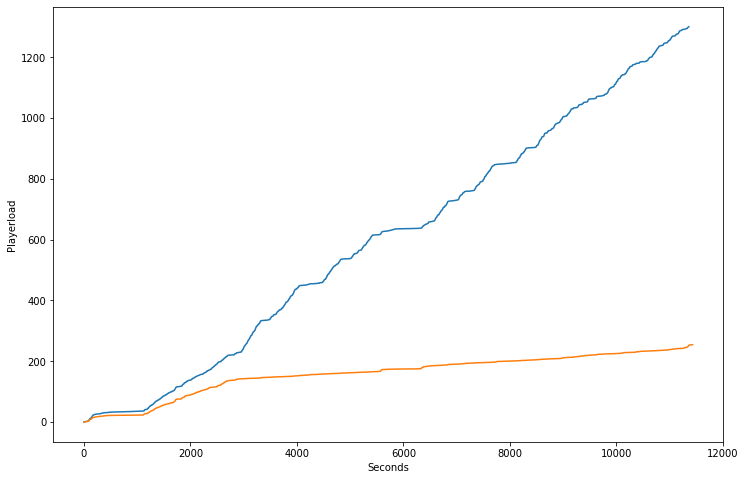

In [21]:
(Game_3_8_df.query("AthleteID == 'Athlete 10' or AthleteID == 'Athlete 6'")
    .groupby("AthleteID")
    .plot(x="Seconds",y="Player Load", ax=plt.gca(), ylabel="Playerload", figsize=(12,8), legend=False))

AthleteID
Athlete 10    AxesSubplot(0.125,0.125;0.775x0.755)
Athlete 6     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

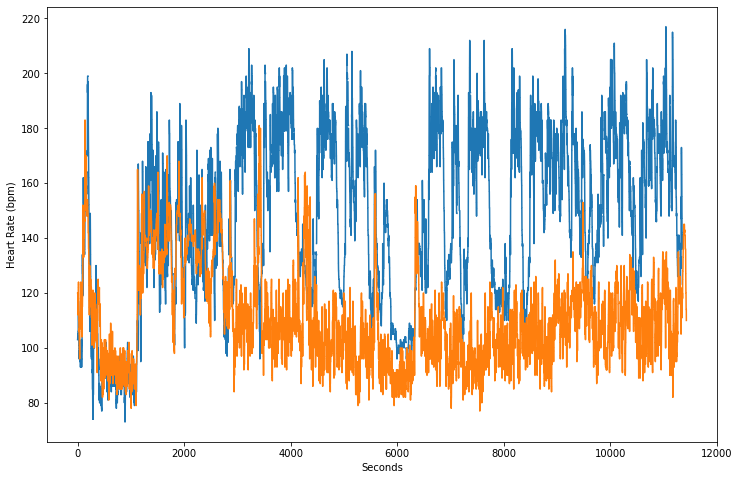

In [22]:
(Game_3_8_df.query("AthleteID == 'Athlete 10' or AthleteID == 'Athlete 6'")
    .groupby("AthleteID")
    .plot(x="Seconds",y="Heart Rate", ax=plt.gca(), ylabel="Heart Rate (bpm)", figsize=(12,8), legend=False))

It is great to get a look directly at the HR and playerload data to make sure everything is making sense before we try to quanitify the effort of the session.

In this case, player 10 (chosen due to having the highest playerload) has a nearly constantly increasing playerload -- and maintained a very high heart rate throughout the game.  Note the significant drop at 6000 seconds.  I feel  confident this was the half-time period (break).  The other low period that is around 1000 seconds -- is likely during some stretching just prior to the on court warm-up (performed by all players) just prior to the beginning of the game. 

We chose Athlete 6 as they had the lowest playerload for this day.  Consistent with this -- they have a steeper increase in load and a higher heart rate only for the warm-up portion of the game.... and then they appear to be (at least) mostly spectating from then on.  Although it is possible for Catapult Sports devices to collect only during times that players are "live" in the game -- we can see that this collection is continuous from before the game until after game (and even during the half-time break).

Okay -- enough "looking around" at this dataset -- time for us to do something to quantify the internal efforts of these players during this game day session. 

Let's start with a simple look at the mean heart rate the entire team had for the day: 

<AxesSubplot:xlabel='Seconds'>

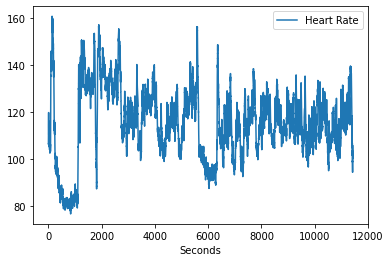

In [23]:
Team_Mean_HR2 = Game_3_8_df.groupby(['Seconds'])[['Heart Rate']].mean()
Team_Mean_HR2.plot(y='Heart Rate')

We can see a very consistent profile here -- of a brief HR increase by players in the game right after the start of the Catapult device -- followed by a decrease down near resting levels in the first 1200 seconds (20 minutes) of the collection.  From that point forward, the team has an average HR that is pretty high with the exception of the half-time period which is about 6000 seconds (or 100 minutes) into the collection.

### Calculation of the individual athlete internal loads for the game session

Now, let's break begin to break this down by athlete number to see what kind of mean heart rates were present for the athletes in the collection.

In [24]:
Rank_Mean_HR = Game_3_8_df.groupby(['AthleteID'])[['Heart Rate']].mean()

print("Average heart rate by player ID")
print(Rank_Mean_HR.sort_values(by='Heart Rate', ascending = False))

Average heart rate by player ID
            Heart Rate
AthleteID             
Athlete 9   149.978586
Athlete 1   148.917603
Athlete 10  147.603970
Athlete 5   142.213841
Athlete 8   112.675939
Athlete 6   111.462357
Athlete 2   108.454120
Athlete 3   105.080676
Athlete 13   97.917628
Athlete 11   96.345663
Athlete 4    84.999233
Athlete 12   83.661286


Surprisingly -- our player with the lowest playerload on the day is far from the lowest mean heart rate across the session.  

We see here that Athlete 12 is listed as having a mean heart rate of only about 83 beats per minute across the entire period.  Let's take a look at the data for this athlete - and do a quick comparison with the player 6 (who had the lowest player load).  

We'll use a slightly different plotting strategy this time.

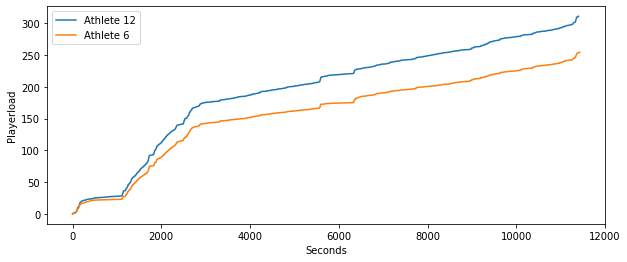

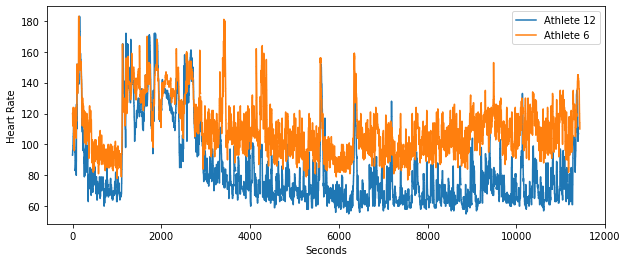

In [25]:
Ath12_Game_3_8_df = Game_3_8_df.loc[Game_3_8_df['AthleteID'] == 'Athlete 12']   

x1_coords = Ath12_Game_3_8_df['Seconds']
x2_coords = Ath6_Game_3_8_df['Seconds']
y1_coords= Ath12_Game_3_8_df['Player Load']
y2_coords= Ath6_Game_3_8_df['Player Load']
plt.figure(figsize=(10, 4))
plt.plot(x1_coords, y1_coords, label="Athlete 12")
plt.plot(x2_coords, y2_coords, label ="Athlete 6")
plt.xlabel('Seconds')
plt.ylabel('Playerload')
plt.legend()
plt.show()

x1_coords= Ath12_Game_3_8_df['Seconds']
x2_coords = Ath6_Game_3_8_df['Seconds']
y1_coords= Ath12_Game_3_8_df['Heart Rate']
y2_coords= Ath6_Game_3_8_df['Heart Rate']
plt.figure(figsize=(10, 4))
plt.plot(x1_coords, y1_coords, label="Athlete 12")
plt.plot(x2_coords, y2_coords, label ="Athlete 6")
plt.xlabel('Seconds')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

Remember that this includes warm-up, breaks (including half-time) and probably even a few minutes after the game.  This particular game was a double overtime game -- so it has 2 extra periods after the regular game periods ended.    An interesting difference between these two players is that Athlete 12 ends up with a higher playerload for the day (mostly due to greater exertion during the warm-up) -- but subsequently maintains heart rates that are ~ 20 beats lower than Athlete 6.  

Let's presume for a moment that the coach wants to use heart rate as a means of determining who needs the most training the day after the game (since the athletes not in the game will not have received much training on game day!)   Of course, the coach could just use the playerload that the athletes had for the day -- and that could be quite reasonable.  But let's a different measure.  We'll use the "TRIMP" or training impulse measure.  

In [26]:
print("Average heart rate by player ID")
print(Rank_Mean_HR.sort_values(by='Heart Rate', ascending = False))

Average heart rate by player ID
            Heart Rate
AthleteID             
Athlete 9   149.978586
Athlete 1   148.917603
Athlete 10  147.603970
Athlete 5   142.213841
Athlete 8   112.675939
Athlete 6   111.462357
Athlete 2   108.454120
Athlete 3   105.080676
Athlete 13   97.917628
Athlete 11   96.345663
Athlete 4    84.999233
Athlete 12   83.661286


Now let's also look at a more involved measure of internal player effort.  This measure will incorporate in the maximal and resting heart rates of each player in order to make the measure more individualized.  

We'll keep it simple and use 200 beats per minute as their (predicted) maximum -- and use 60 beats per minute as their (predicted) resting heart rate.   Using these two values, we know that their heart rate reserve is 140 beats per minute (200-60).  The "TRIMP" measure (or training impulse) uses this heart rate reserve to suggest how intense the session was for each player using only heart rate.    The calculation is as follows: 

TRIMP = t * k * FHRR   (Expressed as an arbitrary unit)

t=minutes of the bout of exercise

k = a constant based on sex of the athlete 

FHRR is the fraction of the heart rate reserve that they had during the session.  This is calculated as the (HR avg - HR rest) / (HR max - HR rest)

So we have the minutes of exercise in the session (based on what was recorded by Catapult) and we have the mean HR across the period.  So we have what we need to calculate the TRIMP value.  

In [27]:
t= 12000/60  # 12000 seconds divided by 60 to provide minutes (200 minutes in this double-overtime game with warm-up time included)

HRmax=200
HRrest=60

FHRR = (Rank_Mean_HR['Heart Rate']-HRrest)/ (HRmax-HRrest)

In [28]:
kval = (np.exp(1.67 * FHRR))
print(FHRR)

TRIMP = t * FHRR * kval

AthleteID
Athlete 1     0.635126
Athlete 10    0.625743
Athlete 11    0.259612
Athlete 12    0.169009
Athlete 13    0.270840
Athlete 2     0.346101
Athlete 3     0.322005
Athlete 4     0.178566
Athlete 5     0.587242
Athlete 6     0.367588
Athlete 8     0.376257
Athlete 9     0.642704
Name: Heart Rate, dtype: float64


In [29]:
InternalLoads=pd.concat([TRIMP, Rank_Mean_HR], axis=1)
InternalLoads.columns=['TRIMP Values','MEAN HR Values']
print(InternalLoads)

            TRIMP Values  MEAN HR Values
AthleteID                               
Athlete 1     366.883756      148.917603
Athlete 10    355.843657      147.603970
Athlete 11     80.102068       96.345663
Athlete 12     44.824752       83.661286
Athlete 13     85.148279       97.917628
Athlete 2     123.381447      108.454120
Athlete 3     110.263911      105.080676
Athlete 4      48.121314       84.999233
Athlete 5     313.153125      142.213841
Athlete 6     135.829166      111.462357
Athlete 8     141.059590      112.675939
Athlete 9     375.990039      149.978586


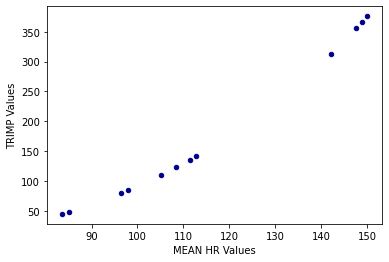

In [30]:
ax1=InternalLoads.plot.scatter(x='MEAN HR Values', y='TRIMP Values', c='DarkBlue')

As TRIMP is effectively calculated from an equation using the mean heart rate - we should expect that there would be a tight relationship here.  However, this hammers home the point that the training response is not linear to heart rate - but rather hightlights that the higher the heart rate goes, the greater the trainin "impulse" will be.  An important thing to keep in mind is the players who do not have any more much "play time" in a game - have (in some ways) missed a day of training.  If the players have the next day off - it is common that the people on the bench do NOT have the day off - but rather use it as a training day since they effectively had a very light day on game day.

In [31]:
Rank_Max_PL
InternalLoads['Player Load']=Rank_Max_PL['Player Load']
print(InternalLoads)

            TRIMP Values  MEAN HR Values  Player Load
AthleteID                                            
Athlete 1     366.883756      148.917603        837.2
Athlete 10    355.843657      147.603970       1300.7
Athlete 11     80.102068       96.345663        271.3
Athlete 12     44.824752       83.661286        311.2
Athlete 13     85.148279       97.917628        305.1
Athlete 2     123.381447      108.454120        458.6
Athlete 3     110.263911      105.080676        301.3
Athlete 4      48.121314       84.999233        383.6
Athlete 5     313.153125      142.213841       1000.6
Athlete 6     135.829166      111.462357        254.4
Athlete 8     141.059590      112.675939        452.1
Athlete 9     375.990039      149.978586        958.2


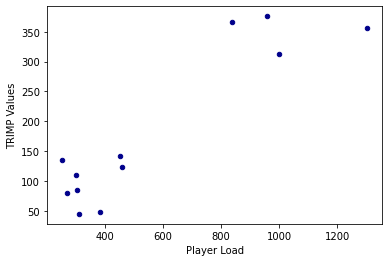

In [32]:
ax1=InternalLoads.plot.scatter(x='Player Load', y='TRIMP Values', c='DarkBlue')

So this figure demonstrates a strong relationship between the TRIMP values and the Playerload - but it is not exactly one to one.  It is clearly noticeable that 4 players had a very high TRIMP value and PlayerLoad (Athletes 1, 10, 5, and 9) -- compared to the rest of the team.  However, it is worth noting that a basketball team has 5 players on the court.  So, this suggests that the "5th player" either did not have a Catapult device on -- or (possibly) was being substituted frequently by several of the athletes with lower scores (especially Athletes 2 and 8 who had higher player loads AND TRIMP values compared to the others.)

One important distinction is that players on the bench can have very elevated HR's from the excitement of the game - that is not tightly linked to the playerload.  This seems to be the case for player 6 - who has the lowest playerload -- but quite a high TRIMP score!  This is something to keep in mind as next week we will discuss more about the combination of using both internal and external measures of load or effort.